# Plotting exp vs. obs for choice genes

In the analysis I have widdled down the number of genes to examine the expected and observed number of mutations for to TP53, KRAS, EGFR, PIK3CA and BRAF. These show up in the chi2-gof test AND the alone-factor, so I want them to be the main focus of my results.

## Setup

In [1]:
library("ggplot2")
library('dplyr')

Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘dplyr’ was built under R version 4.2.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




## Data

In [2]:
# We define our age-interval order
age_interval_levels <- c('<45',
                         '[45-55[',
                         '[55-65[',
                         '[65-75[',
                         '>=75')

In [3]:
# Alone-factor
## General
general_alone_factor <- read.csv("../../derived_data/genie_v15/g_alone_factor.csv", header=TRUE, stringsAsFactors=FALSE)
general_alone_factor <- general_alone_factor %>% select(-group)
general_alone_factor <- cbind(cancer_type = 'General', general_alone_factor)
#head(general_alone_factor)
dim(general_alone_factor)

## Cancer-specific
cs_alone_factor <- read.csv("../../derived_data/genie_v15/cs_alone_factor.csv", header=TRUE, stringsAsFactors=FALSE)
cs_alone_factor <- cs_alone_factor %>% select(-group)
#head(cs_alone_factor)
dim(cs_alone_factor)

## Combine
alone_factor <- rbind(general_alone_factor, cs_alone_factor)
alone_factor$age_interval <- factor(alone_factor$age_interval, levels=age_interval_levels)
head(alone_factor)
dim(alone_factor)

[1] 1292133       6

[1] 1104470       6

,cancer_type,age_interval,sex,sample_type,Hugo_Symbol,alone_factor
,<chr>,<fct>,<chr>,<chr>,<chr>,<dbl>
1,General,<45,Male,Primary,BRAF,0.3333333
2,General,<45,Male,Primary,FBXW7,0.3333333
3,General,<45,Male,Primary,NOTCH1,0.3333333
4,General,<45,Male,Primary,TP53,0.3333333
5,General,<45,Male,Primary,FGFR3,0.3333333
6,General,<45,Male,Primary,APC,0.3333333


[1] 2396603       6

In [4]:
# General expectation
general_expectation <- read.csv("../../derived_data/chi2_gof_test_expectations/general.csv", header=TRUE, stringsAsFactors=FALSE)
general_expectation <- general_expectation %>% select(-X)
general_expectation$age_interval <- factor(general_expectation$age_interval, levels=age_interval_levels)
dim(general_expectation)
head(general_expectation)

[1] 33820     5

,Hugo_Symbol,age_interval,SEX,SAMPLE_TYPE,hypothesis_freq
,<chr>,<fct>,<chr>,<chr>,<dbl>
1,MUTYH,<45,Male,Primary,0.3418843
2,FGF19,<45,Male,Primary,0.3418843
3,DDR2,<45,Male,Primary,0.3418843
4,HRAS,<45,Male,Primary,0.3418843
5,CDKN2A,<45,Male,Primary,0.3418843
6,TP53,<45,Male,Primary,0.3418843


In [5]:
# Ovarian cancer expectation
ovarian_expectation <- read.csv("../../derived_data/chi2_gof_test_expectations/Ovarian_Cancer.csv", header=TRUE, stringsAsFactors=FALSE)
ovarian_expectation <- ovarian_expectation %>% select(-X)
ovarian_expectation$age_interval <- factor(ovarian_expectation$age_interval, levels=age_interval_levels)
dim(ovarian_expectation)
head(ovarian_expectation)

[1] 11820     6

,CANCER_TYPE,Hugo_Symbol,age_interval,SEX,SAMPLE_TYPE,hypothesis_freq
,<chr>,<chr>,<fct>,<chr>,<chr>,<dbl>
1,Ovarian Cancer,MUTYH,<45,Female,Primary,0.1161432
2,Ovarian Cancer,TRGV11,<45,Female,Primary,0.1161432
3,Ovarian Cancer,GPC3,<45,Female,Primary,0.1161432
4,Ovarian Cancer,DDR2,<45,Female,Primary,0.1425572
5,Ovarian Cancer,HRAS,<45,Female,Primary,0.1425572
6,Ovarian Cancer,CDKN2A,<45,Female,Primary,0.1425572


In [6]:
# Melanoma expectation
melanoma_expectation <- read.csv("../../derived_data/chi2_gof_test_expectations/Melanoma.csv", header=TRUE, stringsAsFactors=FALSE)
melanoma_expectation <- melanoma_expectation %>% select(-X)
melanoma_expectation$age_interval <- factor(melanoma_expectation$age_interval, levels=age_interval_levels)
dim(melanoma_expectation)
head(melanoma_expectation)

[1] 15340     6

,CANCER_TYPE,Hugo_Symbol,age_interval,SEX,SAMPLE_TYPE,hypothesis_freq
,<chr>,<chr>,<fct>,<chr>,<chr>,<dbl>
1,Melanoma,DDR2,<45,Male,Primary,0.1618487
2,Melanoma,HRAS,<45,Male,Primary,0.1618487
3,Melanoma,H3F3A,<45,Male,Primary,0.1618487
4,Melanoma,TSHR,<45,Male,Primary,0.1618487
5,Melanoma,MET,<45,Male,Primary,0.1618487
6,Melanoma,TP53,<45,Male,Primary,0.1618487


In [7]:
# General observation
general_observation <- read.csv("../../derived_data/chi2_gof_test_observations/general.csv", header=TRUE, stringsAsFactors=FALSE)
general_observation <- general_observation %>% select(-X)

head(general_observation)

,Hugo_Symbol,age_interval,SEX,SAMPLE_TYPE,n
,<chr>,<chr>,<chr>,<chr>,<int>
1,ABL1,<45,Female,Metastasis,9
2,ABL1,<45,Female,Primary,29
3,ABL1,<45,Male,Metastasis,13
4,ABL1,<45,Male,Primary,20
5,ABL1,[45-55[,Female,Metastasis,24
6,ABL1,[45-55[,Female,Primary,51


To find the observed mutations for KRAS and BRAF we have to find htem again as they are not saved, but we are only interested in the Primary and Female groups, as that is where they were significant. To do this we first need the pathogen dataset to be loaded and wrangled.

In [8]:
pathogen <- read.csv("../../derived_data/genie_v15/pathogen_filtered_50.csv")

# We select the columns of interest from the pathogen data
pathogen <- pathogen %>% select('Hugo_Symbol','sample_id','patient_id','age','age_group','sex','sample_type', 'cancer_type')

# Define our age-intervals
pathogen$age_interval <- '<45'
pathogen$age_interval[pathogen$age>=45] <- '[45-55['
pathogen$age_interval[pathogen$age>=55] <- '[55-65['
pathogen$age_interval[pathogen$age>=65] <- '[65-75['
pathogen$age_interval[pathogen$age>=75] <- '>=75'

# And use them to make age-interval a factor in our pathogen data
pathogen$age_interval <- factor(pathogen$age_interval, levels=age_interval_levels)

pathogen$SEX <- NA
pathogen <- pathogen %>% mutate(SEX = case_when(sex == 'Female' ~ 'Female',
                                                sex == 'Male' ~ 'Male'))

pathogen$SAMPLE_TYPE <- NA
pathogen <- pathogen %>% mutate(SAMPLE_TYPE = case_when(sample_type == 'Primary' ~ 'Primary',
                                                        sample_type == 'Metastasis' ~ 'Metastasis'))

pathogen <- na.omit(pathogen)
pathogen <- pathogen %>% select(-sex, -sample_type)

pathogen <- pathogen[!duplicated(pathogen[,]),]
dim(pathogen)

[1] 408661      9

Then we can find the observd number of mutations.

In [9]:
# Melanoma observed

# Silencing the summarise warning from dyplr
options(dplyr.summarise.inform = FALSE)

# Selecting only pathogens found in in our cancer-type
malanoma_pathogens <- pathogen[which(pathogen$cancer_type == 'Melanoma'),]

melanoma_observed_mutations <- malanoma_pathogens %>%
  group_by(Hugo_Symbol,age_interval,SEX,SAMPLE_TYPE) %>%
  summarise(n = n())

melanoma_observed_mutations$age_interval <- factor(melanoma_observed_mutations$age_interval, levels=age_interval_levels)

melanoma_observed_mutations <- as.data.frame(melanoma_observed_mutations)

for (age_lvl in age_interval_levels){
    for (mut in c('KRAS', 'BRAF')){
        tmp <- melanoma_observed_mutations[which(melanoma_observed_mutations$age_interval==age_lvl & melanoma_observed_mutations$Hugo_Symbol==mut & melanoma_observed_mutations$SEX=='Female' & melanoma_observed_mutations$SAMPLE_TYPE=='Primary'),]
        if (nrow(tmp)==0){
            melanoma_observed_mutations[nrow(melanoma_observed_mutations)+1, 1] = mut
            melanoma_observed_mutations[nrow(melanoma_observed_mutations), 2] = age_lvl
            melanoma_observed_mutations[nrow(melanoma_observed_mutations), 3] = 'Female'
            melanoma_observed_mutations[nrow(melanoma_observed_mutations), 4] = 'Primary'
            melanoma_observed_mutations[nrow(melanoma_observed_mutations), 5] = 0
        }
        
        tmp <- melanoma_observed_mutations[which(melanoma_observed_mutations$age_interval==age_lvl & melanoma_observed_mutations$Hugo_Symbol==mut & melanoma_observed_mutations$SEX=='Female' & melanoma_observed_mutations$SAMPLE_TYPE=='Metastasis'),]
        if (nrow(tmp)==0){
            melanoma_observed_mutations[nrow(melanoma_observed_mutations)+1, 1] = mut
            melanoma_observed_mutations[nrow(melanoma_observed_mutations), 2] = age_lvl
            melanoma_observed_mutations[nrow(melanoma_observed_mutations), 3] = 'Female'
            melanoma_observed_mutations[nrow(melanoma_observed_mutations), 4] = 'Metastasis'
            melanoma_observed_mutations[nrow(melanoma_observed_mutations), 5] = 0
        }
    }
}

head(melanoma_observed_mutations)

,Hugo_Symbol,age_interval,SEX,SAMPLE_TYPE,n
,<chr>,<fct>,<chr>,<chr>,<dbl>
1,ABL1,<45,Female,Metastasis,1
2,ABL1,<45,Female,Primary,2
3,ABL1,<45,Male,Metastasis,2
4,ABL1,[45-55[,Female,Metastasis,1
5,ABL1,[45-55[,Male,Metastasis,1
6,ABL1,[45-55[,Male,Primary,1


In [10]:
# Ovarian cancer observed

# Silencing the summarise warning from dyplr
options(dplyr.summarise.inform = FALSE)

# Selecting only pathogens found in in our cancer-type
malanoma_pathogens <- pathogen[which(pathogen$cancer_type == 'Ovarian Cancer'),]

ovarian_observed_mutations <- malanoma_pathogens %>%
  group_by(Hugo_Symbol,age_interval,SEX,SAMPLE_TYPE) %>%
  summarise(n = n())

ovarian_observed_mutations$age_interval <- factor(ovarian_observed_mutations$age_interval, levels=age_interval_levels)

ovarian_observed_mutations <- as.data.frame(ovarian_observed_mutations)

for (age_lvl in age_interval_levels){
    for (mut in c('KRAS', 'BRAF')){
        tmp <- ovarian_observed_mutations[which(ovarian_observed_mutations$age_interval==age_lvl & ovarian_observed_mutations$Hugo_Symbol==mut & ovarian_observed_mutations$SEX=='Female' & ovarian_observed_mutations$SAMPLE_TYPE=='Primary'),]
        if (nrow(tmp)==0){
            ovarian_observed_mutations[nrow(ovarian_observed_mutations)+1, 1] = mut
            ovarian_observed_mutations[nrow(ovarian_observed_mutations), 2] = age_lvl
            ovarian_observed_mutations[nrow(ovarian_observed_mutations), 3] = 'Female'
            ovarian_observed_mutations[nrow(ovarian_observed_mutations), 4] = 'Primary'
            ovarian_observed_mutations[nrow(ovarian_observed_mutations), 5] = 0
        }
        
        tmp <- ovarian_observed_mutations[which(ovarian_observed_mutations$age_interval==age_lvl & ovarian_observed_mutations$Hugo_Symbol==mut & ovarian_observed_mutations$SEX=='Female' & ovarian_observed_mutations$SAMPLE_TYPE=='Metastasis'),]
        if (nrow(tmp)==0){
            ovarian_observed_mutations[nrow(ovarian_observed_mutations)+1, 1] = mut
            ovarian_observed_mutations[nrow(ovarian_observed_mutations), 2] = age_lvl
            ovarian_observed_mutations[nrow(ovarian_observed_mutations), 3] = 'Female'
            ovarian_observed_mutations[nrow(ovarian_observed_mutations), 4] = 'Metastasis'
            ovarian_observed_mutations[nrow(ovarian_observed_mutations), 5] = 0
        }
    }
}

head(ovarian_observed_mutations)

,Hugo_Symbol,age_interval,SEX,SAMPLE_TYPE,n
,<chr>,<fct>,<chr>,<chr>,<int>
1,ABL1,<45,Female,Metastasis,1
2,ABL1,<45,Female,Primary,2
3,ABL1,[45-55[,Female,Metastasis,1
4,ABL1,[45-55[,Female,Primary,5
5,ABL1,[55-65[,Female,Metastasis,1
6,ABL1,[55-65[,Female,Primary,2


## Expected vs. observed

### TP53

In [11]:
g_exp_TP53 <- general_expectation %>% filter(Hugo_Symbol == 'TP53')

g_obs_TP53 <- general_observation %>% filter(Hugo_Symbol == 'TP53')

TP53 <- left_join(g_obs_TP53, g_exp_TP53, by=c('Hugo_Symbol', 'age_interval', 'SEX', 'SAMPLE_TYPE'))

TP53$age_interval <- factor(TP53$age_interval, levels=age_interval_levels)
TP53$SAMPLE_TYPE <- factor(TP53$SAMPLE_TYPE, levels=c('Primary', 'Metastasis'))

head(TP53)

,Hugo_Symbol,age_interval,SEX,SAMPLE_TYPE,n,hypothesis_freq
,<chr>,<fct>,<chr>,<fct>,<int>,<dbl>
1,TP53,<45,Female,Metastasis,1079,0.16356000
2,TP53,<45,Female,Primary,1753,0.38871637
3,TP53,<45,Male,Metastasis,592,0.30684233
4,TP53,<45,Male,Primary,1438,0.34188429
5,TP53,[45-55[,Female,Metastasis,1930,0.16675748
6,TP53,[45-55[,Female,Primary,2352,0.07846015


In [12]:
TP53_af <- alone_factor %>% filter(cancer_type == 'General' & Hugo_Symbol == 'TP53')

TP53_af <- TP53_af %>% group_by(Hugo_Symbol, age_interval, sex, sample_type) %>% summarise(mean_af = mean(alone_factor))

TP53 <- left_join(TP53, TP53_af, by=c('Hugo_Symbol', 'age_interval', 'SEX'='sex', 'SAMPLE_TYPE'='sample_type'))

head(TP53)

,Hugo_Symbol,age_interval,SEX,SAMPLE_TYPE,n,hypothesis_freq,mean_af
,<chr>,<fct>,<chr>,<chr>,<int>,<dbl>,<dbl>
1,TP53,<45,Female,Metastasis,1079,0.16356000,0.2769060
2,TP53,<45,Female,Primary,1753,0.38871637,0.2592310
3,TP53,<45,Male,Metastasis,592,0.30684233,0.2830421
4,TP53,<45,Male,Primary,1438,0.34188429,0.2370526
5,TP53,[45-55[,Female,Metastasis,1930,0.16675748,0.2624810
6,TP53,[45-55[,Female,Primary,2352,0.07846015,0.2542398


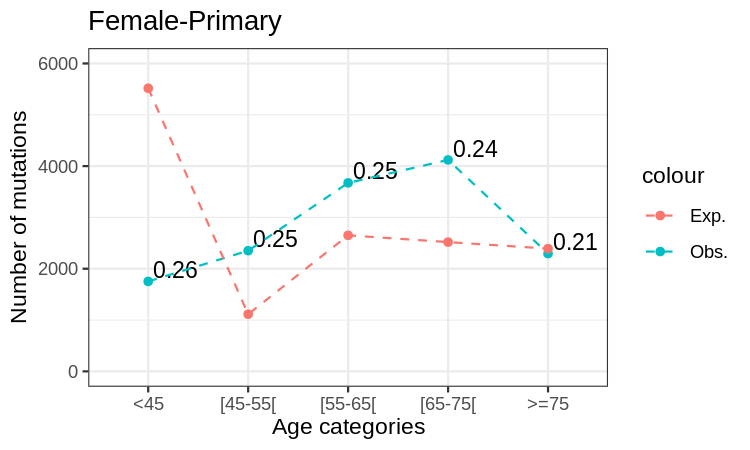

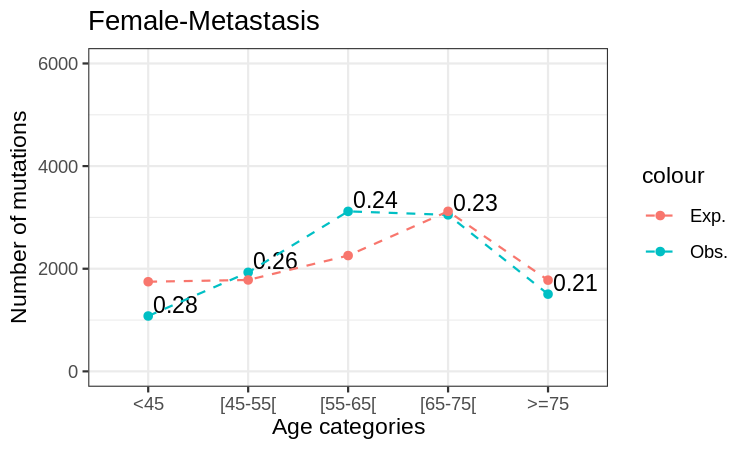

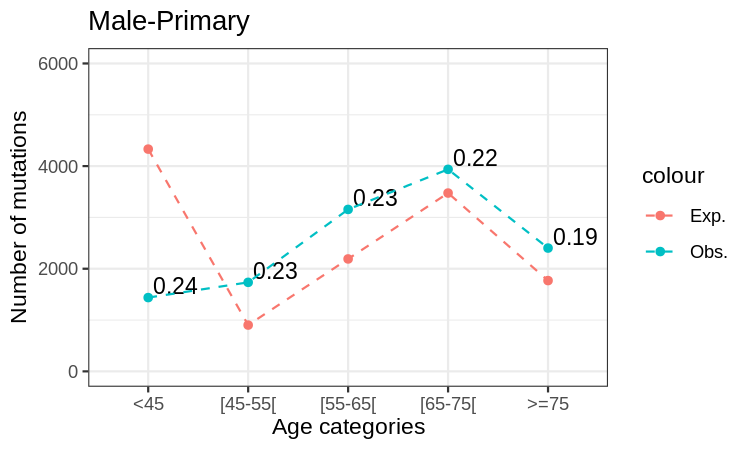

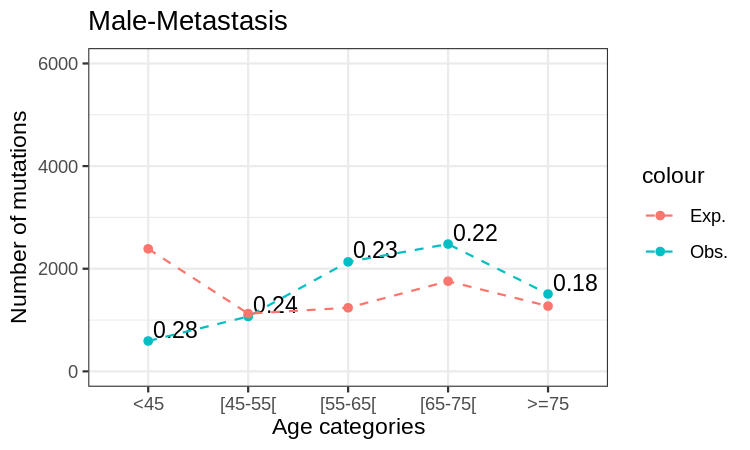

In [14]:
options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 150)

for (the_sex in c('Female', 'Male')){
    for (the_sample_type in c('Primary', 'Metastasis')){
        
        group_TP53 <- TP53 %>% filter(SEX == the_sex & SAMPLE_TYPE == the_sample_type)
        
        scale = sum(group_TP53$n)
        
        group_TP53 <- group_TP53 %>% mutate(exp_scaled = hypothesis_freq * scale)

        q <- ggplot(group_TP53, aes(x=age_interval, y=n, group = interaction(SEX, SAMPLE_TYPE), label=round(mean_af, digits = 2))) +
        geom_point(aes(color = "Obs.")) +
        geom_text(hjust=-0.1, vjust=-0.2) +
        geom_line(aes(color = "Obs."), linetype='dashed') +
        geom_point(aes(y=exp_scaled, color = "Exp.")) +
        geom_line(aes(y=exp_scaled, color = "Exp."), linetype='dashed') +
        theme_bw() +
        ylim(0, 6000) +
        ylab('Number of mutations') +
        xlab('Age categories') +
        ggtitle(paste(the_sex, '-', the_sample_type, sep=''))
        
        print(q)
    }
}




### KRAS

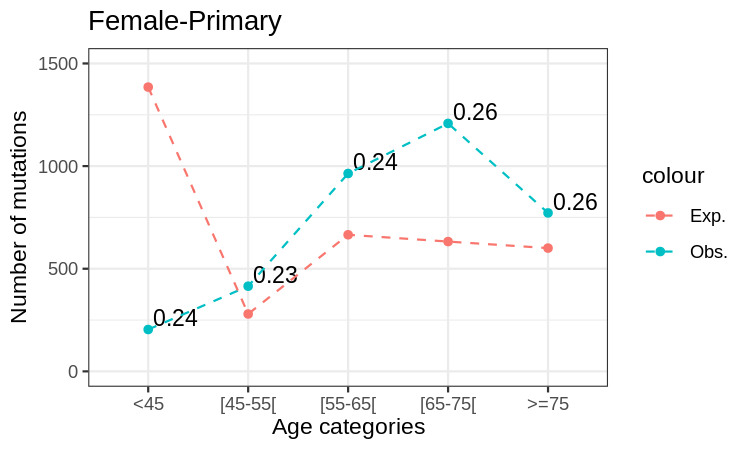

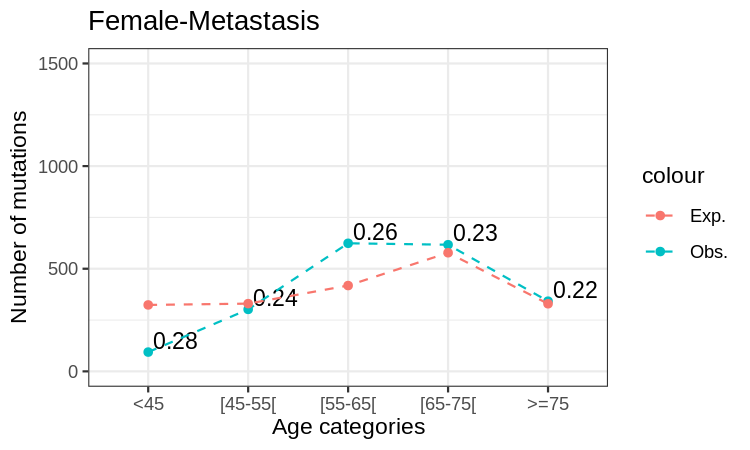

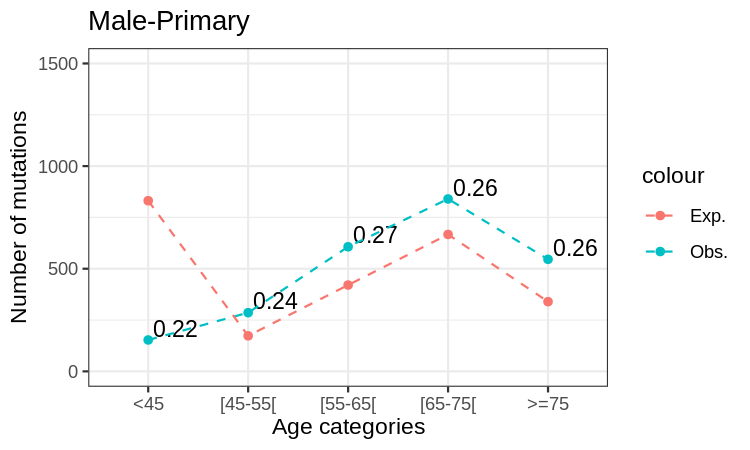

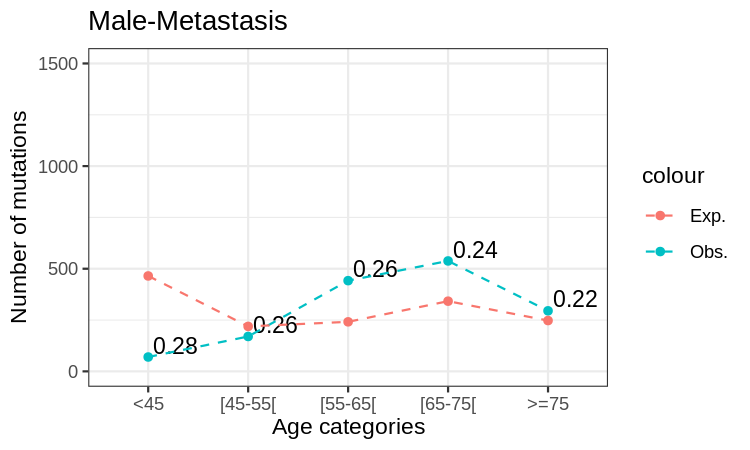

In [15]:
g_exp_KRAS <- general_expectation %>% filter(Hugo_Symbol == 'KRAS')

g_obs_KRAS <- general_observation %>% filter(Hugo_Symbol == 'KRAS')

KRAS <- left_join(g_obs_KRAS, g_exp_KRAS, by=c('Hugo_Symbol', 'age_interval', 'SEX', 'SAMPLE_TYPE'))

KRAS$age_interval <- factor(KRAS$age_interval, levels=age_interval_levels)
KRAS$SAMPLE_TYPE <- factor(KRAS$SAMPLE_TYPE, levels=c('Primary', 'Metastasis'))

KRAS_af <- alone_factor %>% filter(cancer_type == 'General' & Hugo_Symbol == 'KRAS')

KRAS_af <- KRAS_af %>% group_by(Hugo_Symbol, age_interval, sex, sample_type) %>% summarise(mean_af = mean(alone_factor))

KRAS <- left_join(KRAS, KRAS_af, by=c('Hugo_Symbol', 'age_interval', 'SEX'='sex', 'SAMPLE_TYPE'='sample_type'))

options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 150)

for (the_sex in c('Female', 'Male')){
    for (the_sample_type in c('Primary', 'Metastasis')){
        
        group_KRAS <- KRAS %>% filter(SEX == the_sex & SAMPLE_TYPE == the_sample_type)
        
        scale = sum(group_KRAS$n)
        
        group_KRAS <- group_KRAS %>% mutate(exp_scaled = hypothesis_freq * scale)

        q <- ggplot(group_KRAS, aes(x=age_interval, y=n, group = interaction(SEX, SAMPLE_TYPE), label=round(mean_af, digits = 2))) +
        geom_point(aes(color = "Obs.")) +
        geom_text(hjust=-0.1, vjust=-0.2) +
        geom_line(aes(color = "Obs."), linetype='dashed') +
        geom_point(aes(y=exp_scaled, color = "Exp.")) +
        geom_line(aes(y=exp_scaled, color = "Exp."), linetype='dashed') +
        theme_bw() +
        ylim(0, 1500) +
        ylab('Number of mutations') +
        xlab('Age categories') +
        ggtitle(paste(the_sex, '-', the_sample_type, sep=''))
        
        print(q)
    }
}




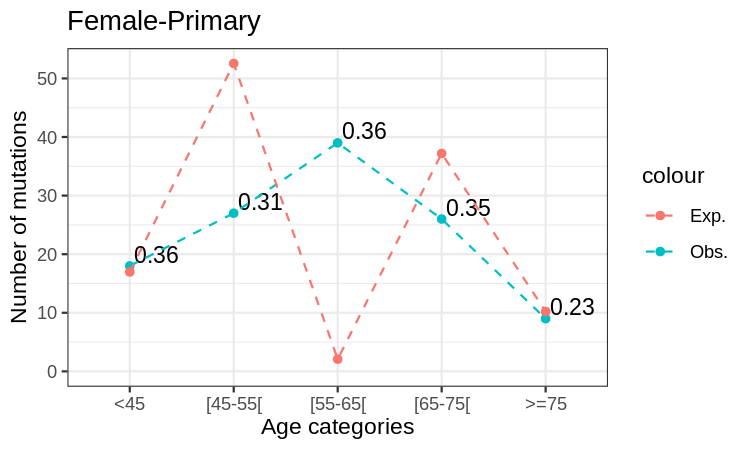

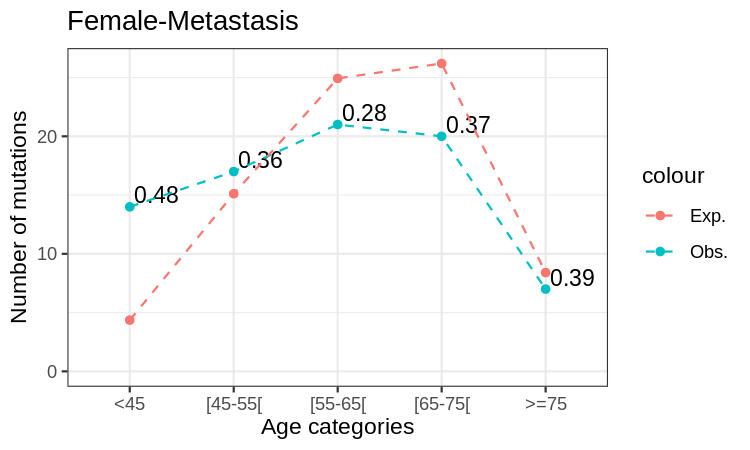

In [16]:
ov_exp_KRAS <- ovarian_expectation %>% filter(Hugo_Symbol == 'KRAS')

ov_obs_KRAS <- ovarian_observed_mutations %>% filter(Hugo_Symbol == 'KRAS')

KRAS <- left_join(ov_obs_KRAS, ov_exp_KRAS, by=c('Hugo_Symbol', 'age_interval', 'SEX', 'SAMPLE_TYPE'))

KRAS$age_interval <- factor(KRAS$age_interval, levels=age_interval_levels)
KRAS$SAMPLE_TYPE <- factor(KRAS$SAMPLE_TYPE, levels=c('Primary', 'Metastasis'))

KRAS_af <- alone_factor %>% filter(cancer_type == 'Ovarian Cancer' & Hugo_Symbol == 'KRAS')

KRAS_af <- KRAS_af %>% group_by(Hugo_Symbol, age_interval, sex, sample_type) %>% summarise(mean_af = mean(alone_factor))

KRAS <- left_join(KRAS, KRAS_af, by=c('Hugo_Symbol', 'age_interval', 'SEX'='sex', 'SAMPLE_TYPE'='sample_type'))

options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 150)

for (the_sample_type in c('Primary', 'Metastasis')){
    
    group_KRAS <- KRAS %>% filter(SAMPLE_TYPE == the_sample_type)
    
    scale = sum(group_KRAS$n)
    
    group_KRAS <- group_KRAS %>% mutate(exp_scaled = hypothesis_freq * scale)

    q <- ggplot(group_KRAS, aes(x=age_interval, y=n, group = interaction(SAMPLE_TYPE), label=round(mean_af, digits = 2))) +
    geom_point(aes(color = "Obs.")) +
    geom_text(hjust=-0.1, vjust=-0.2) +
    geom_line(aes(color = "Obs."), linetype='dashed') +
    geom_point(aes(y=exp_scaled, color = "Exp.")) +
    geom_line(aes(y=exp_scaled, color = "Exp."), linetype='dashed') +
    theme_bw() +
    ylim(0, NA) +
    ylab('Number of mutations') +
    xlab('Age categories') +
    ggtitle(paste('Female-', the_sample_type, sep=''))
    
    print(q)
}


### EGFR

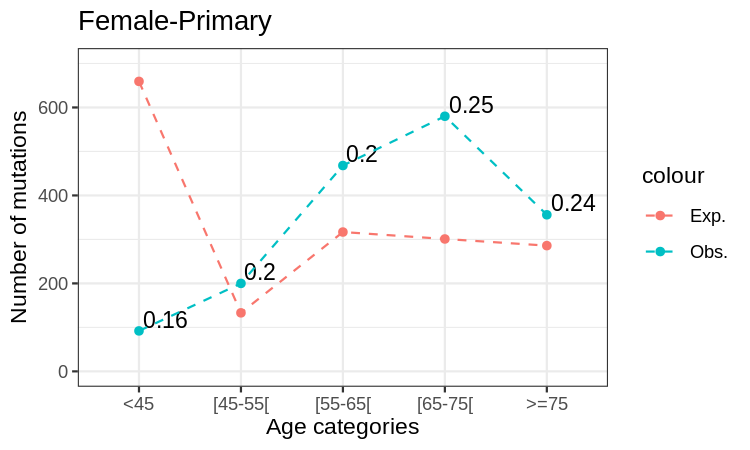

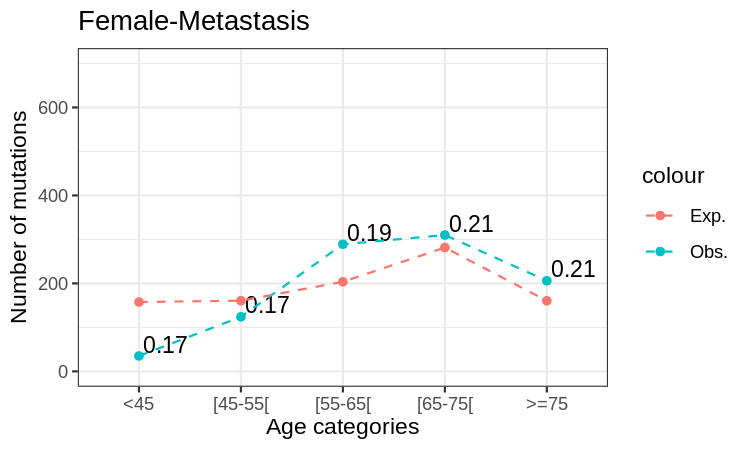

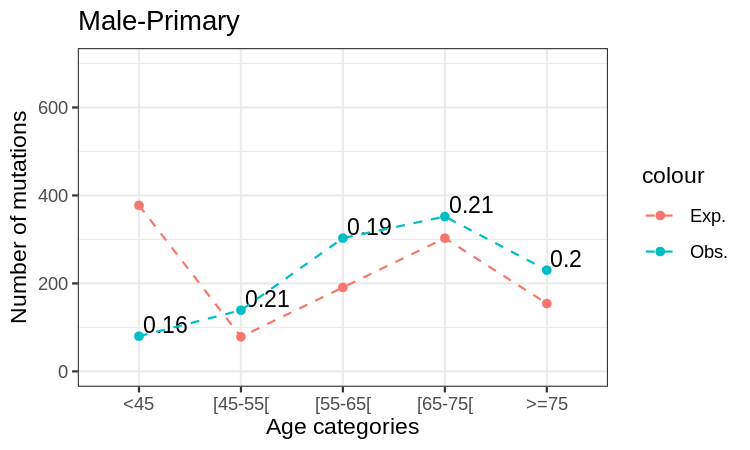

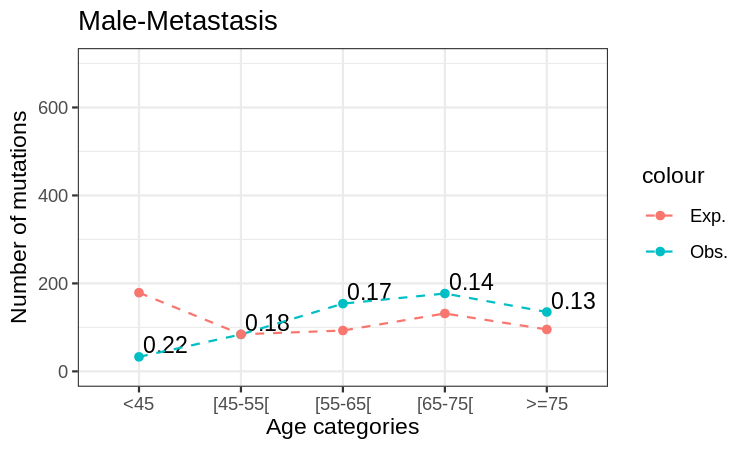

In [17]:
g_exp_EGFR <- general_expectation %>% filter(Hugo_Symbol == 'EGFR')

g_obs_EGFR <- general_observation %>% filter(Hugo_Symbol == 'EGFR')

EGFR <- left_join(g_obs_EGFR, g_exp_EGFR, by=c('Hugo_Symbol', 'age_interval', 'SEX', 'SAMPLE_TYPE'))

EGFR$age_interval <- factor(EGFR$age_interval, levels=age_interval_levels)
EGFR$SAMPLE_TYPE <- factor(EGFR$SAMPLE_TYPE, levels=c('Primary', 'Metastasis'))

EGFR_af <- alone_factor %>% filter(cancer_type == 'General' & Hugo_Symbol == 'EGFR')

EGFR_af <- EGFR_af %>% group_by(Hugo_Symbol, age_interval, sex, sample_type) %>% summarise(mean_af = mean(alone_factor))

EGFR <- left_join(EGFR, EGFR_af, by=c('Hugo_Symbol', 'age_interval', 'SEX'='sex', 'SAMPLE_TYPE'='sample_type'))

options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 150)

for (the_sex in c('Female', 'Male')){
    for (the_sample_type in c('Primary', 'Metastasis')){
        
        group_EGFR <- EGFR %>% filter(SEX == the_sex & SAMPLE_TYPE == the_sample_type)
        
        scale = sum(group_EGFR$n)
        
        group_EGFR <- group_EGFR %>% mutate(exp_scaled = hypothesis_freq * scale)

        q <- ggplot(group_EGFR, aes(x=age_interval, y=n, group = interaction(SEX, SAMPLE_TYPE), label=round(mean_af, digits = 2))) +
        geom_point(aes(color = "Obs.")) +
        geom_text(hjust=-0.1, vjust=-0.2) +
        geom_line(aes(color = "Obs."), linetype='dashed') +
        geom_point(aes(y=exp_scaled, color = "Exp.")) +
        geom_line(aes(y=exp_scaled, color = "Exp."), linetype='dashed') +
        theme_bw() +
        ylim(0, 700) +
        ylab('Number of mutations') +
        xlab('Age categories') +
        ggtitle(paste(the_sex, '-', the_sample_type, sep=''))
        
        print(q)
    }
}




### PIK3CA

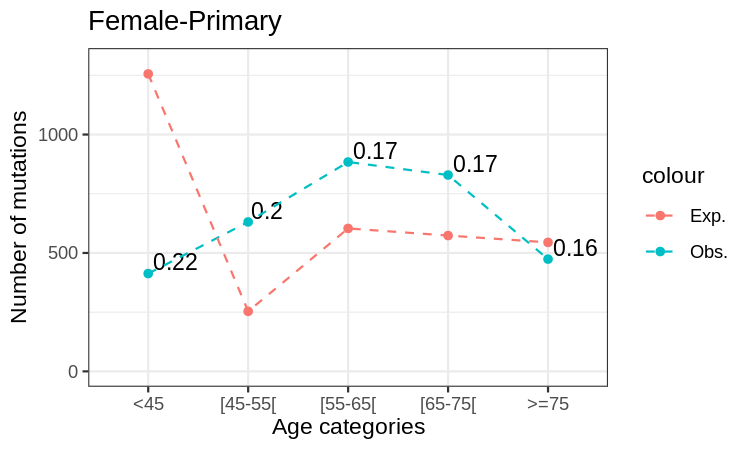

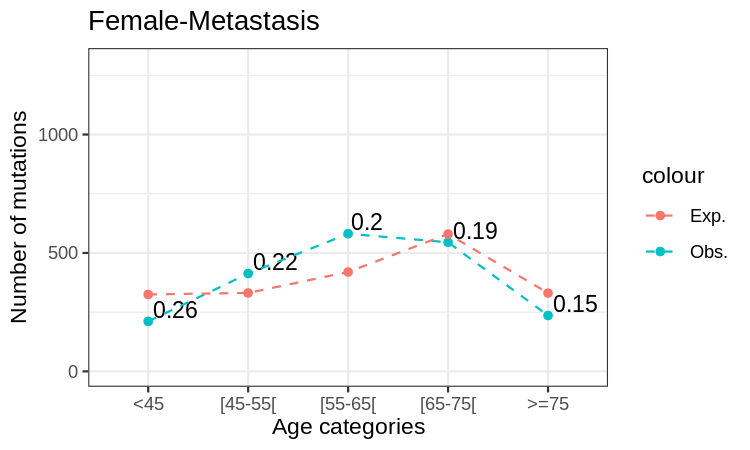

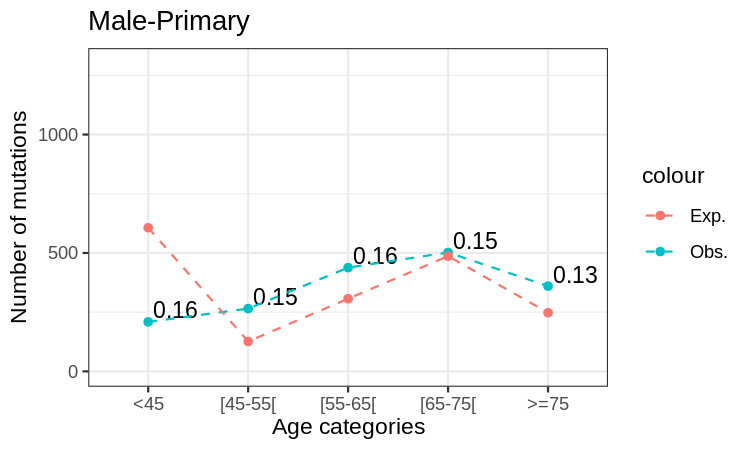

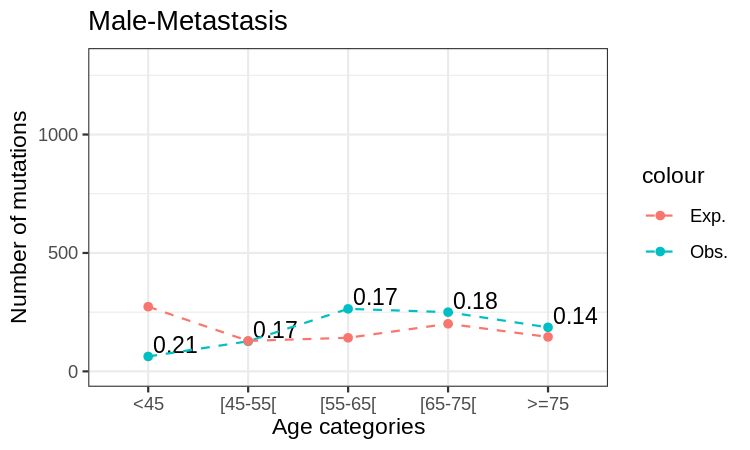

In [18]:
g_exp_PIK3CA <- general_expectation %>% filter(Hugo_Symbol == 'PIK3CA')

g_obs_PIK3CA <- general_observation %>% filter(Hugo_Symbol == 'PIK3CA')

PIK3CA <- left_join(g_obs_PIK3CA, g_exp_PIK3CA, by=c('Hugo_Symbol', 'age_interval', 'SEX', 'SAMPLE_TYPE'))

PIK3CA$age_interval <- factor(PIK3CA$age_interval, levels=age_interval_levels)
PIK3CA$SAMPLE_TYPE <- factor(PIK3CA$SAMPLE_TYPE, levels=c('Primary', 'Metastasis'))

PIK3CA_af <- alone_factor %>% filter(cancer_type == 'General' & Hugo_Symbol == 'PIK3CA')

PIK3CA_af <- PIK3CA_af %>% group_by(Hugo_Symbol, age_interval, sex, sample_type) %>% summarise(mean_af = mean(alone_factor))

PIK3CA <- left_join(PIK3CA, PIK3CA_af, by=c('Hugo_Symbol', 'age_interval', 'SEX'='sex', 'SAMPLE_TYPE'='sample_type'))

options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 150)

for (the_sex in c('Female', 'Male')){
    for (the_sample_type in c('Primary', 'Metastasis')){
        
        group_PIK3CA <- PIK3CA %>% filter(SEX == the_sex & SAMPLE_TYPE == the_sample_type)
        
        scale = sum(group_PIK3CA$n)
        
        group_PIK3CA <- group_PIK3CA %>% mutate(exp_scaled = hypothesis_freq * scale)

        q <- ggplot(group_PIK3CA, aes(x=age_interval, y=n, group = interaction(SEX, SAMPLE_TYPE), label=round(mean_af, digits = 2))) +
        geom_point(aes(color = "Obs.")) +
        geom_text(hjust=-0.1, vjust=-0.2) +
        geom_line(aes(color = "Obs."), linetype='dashed') +
        geom_point(aes(y=exp_scaled, color = "Exp.")) +
        geom_line(aes(y=exp_scaled, color = "Exp."), linetype='dashed') +
        theme_bw() +
        ylim(0, 1300) +
        ylab('Number of mutations') +
        xlab('Age categories') +
        ggtitle(paste(the_sex, '-', the_sample_type, sep=''))
        
        print(q)
    }
}




### BRAF

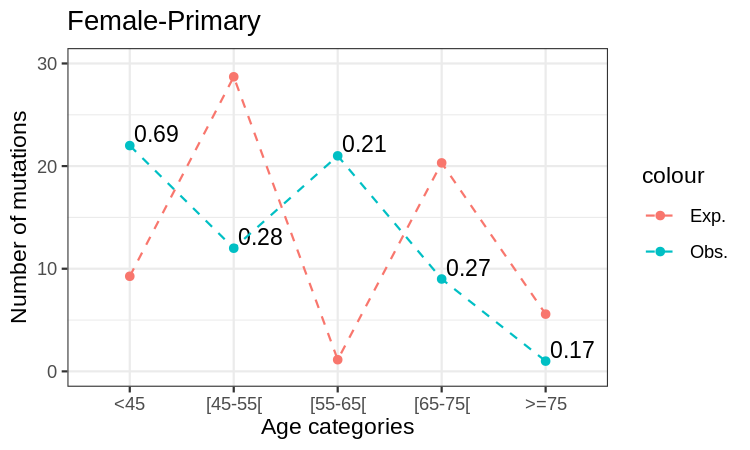

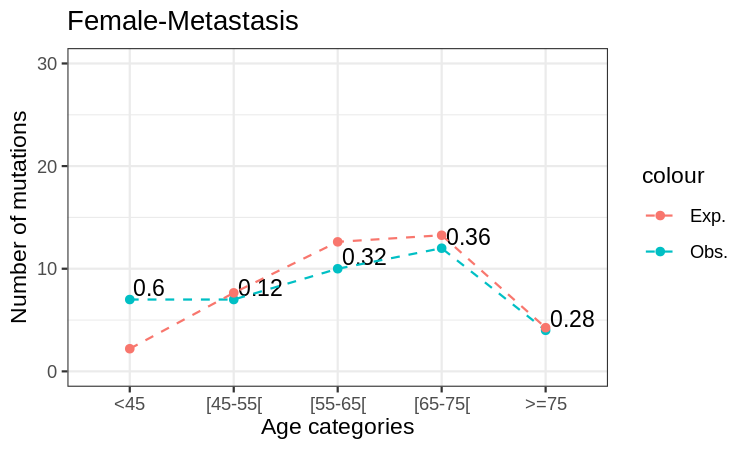

In [19]:
ov_exp_BRAF <- ovarian_expectation %>% filter(Hugo_Symbol == 'BRAF')

ov_obs_BRAF <- ovarian_observed_mutations %>% filter(Hugo_Symbol == 'BRAF')

BRAF <- left_join(ov_obs_BRAF, ov_exp_BRAF, by=c('Hugo_Symbol', 'age_interval', 'SEX', 'SAMPLE_TYPE'))

BRAF$age_interval <- factor(BRAF$age_interval, levels=age_interval_levels)
BRAF$SAMPLE_TYPE <- factor(BRAF$SAMPLE_TYPE, levels=c('Primary', 'Metastasis'))

BRAF_af <- alone_factor %>% filter(cancer_type == 'Ovarian Cancer' & Hugo_Symbol == 'BRAF')

BRAF_af <- BRAF_af %>% group_by(Hugo_Symbol, age_interval, sex, sample_type) %>% summarise(mean_af = mean(alone_factor))

BRAF <- left_join(BRAF, BRAF_af, by=c('Hugo_Symbol', 'age_interval', 'SEX'='sex', 'SAMPLE_TYPE'='sample_type'))

options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 150)

for (the_sample_type in c('Primary', 'Metastasis')){
    
    group_BRAF <- BRAF %>% filter(SAMPLE_TYPE == the_sample_type)
    
    scale = sum(group_BRAF$n)
    
    group_BRAF <- group_BRAF %>% mutate(exp_scaled = hypothesis_freq * scale)

    q <- ggplot(group_BRAF, aes(x=age_interval, y=n, group = interaction(SAMPLE_TYPE), label=round(mean_af, digits = 2))) +
    geom_point(aes(color = "Obs.")) +
    geom_text(hjust=-0.1, vjust=-0.2) +
    geom_line(aes(color = "Obs."), linetype='dashed') +
    geom_point(aes(y=exp_scaled, color = "Exp.")) +
    geom_line(aes(y=exp_scaled, color = "Exp."), linetype='dashed') +
    theme_bw() +
    ylim(0, 30) +
    ylab('Number of mutations') +
    xlab('Age categories') +
    ggtitle(paste('Female-', the_sample_type, sep=''))
    
    print(q)
}


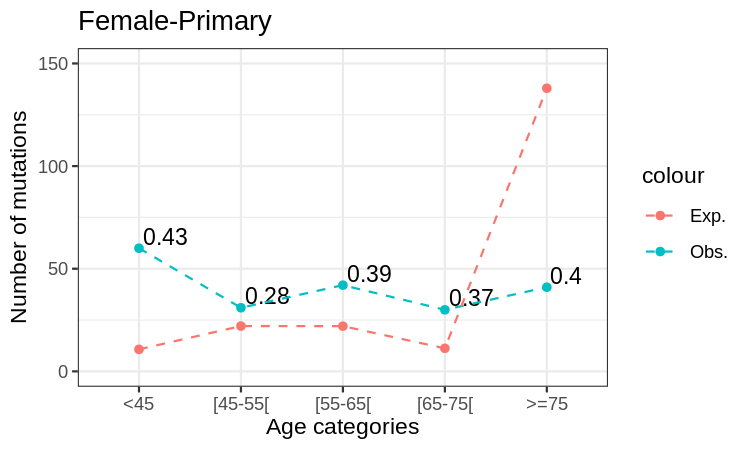

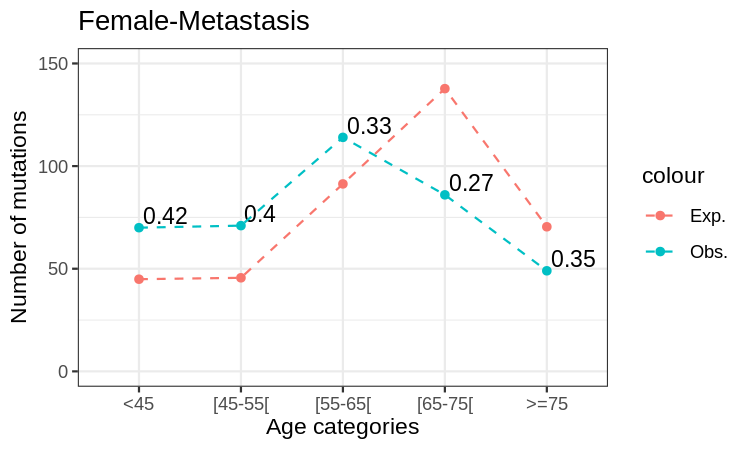

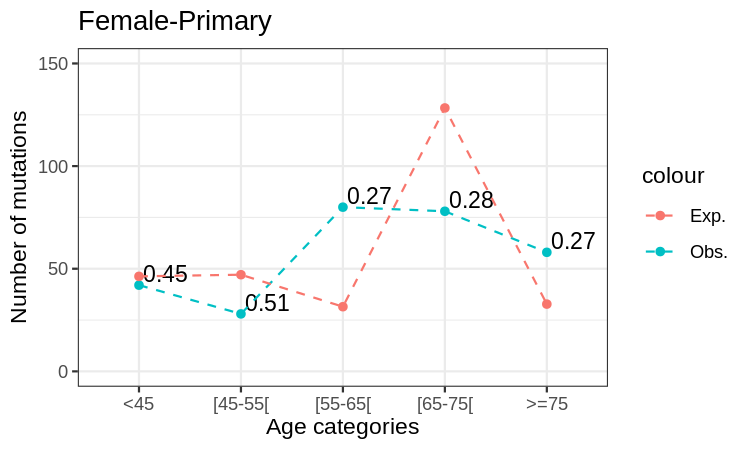

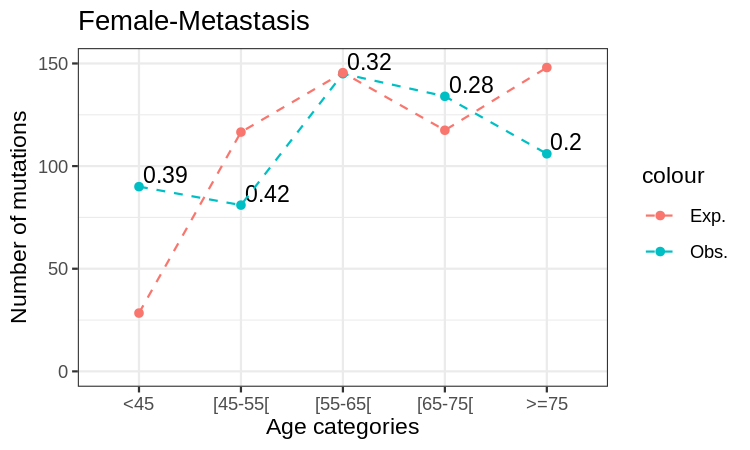

In [20]:
mel_exp_BRAF <- melanoma_expectation %>% filter(Hugo_Symbol == 'BRAF')

mel_obs_BRAF <- melanoma_observed_mutations %>% filter(Hugo_Symbol == 'BRAF')

BRAF <- left_join(mel_obs_BRAF, mel_exp_BRAF, by=c('Hugo_Symbol', 'age_interval', 'SEX', 'SAMPLE_TYPE'))

BRAF$age_interval <- factor(BRAF$age_interval, levels=age_interval_levels)
BRAF$SAMPLE_TYPE <- factor(BRAF$SAMPLE_TYPE, levels=c('Primary', 'Metastasis'))

BRAF_af <- alone_factor %>% filter(cancer_type == 'Melanoma' & Hugo_Symbol == 'BRAF')

BRAF_af <- BRAF_af %>% group_by(Hugo_Symbol, age_interval, sex, sample_type) %>% summarise(mean_af = mean(alone_factor))

BRAF <- left_join(BRAF, BRAF_af, by=c('Hugo_Symbol', 'age_interval', 'SEX'='sex', 'SAMPLE_TYPE'='sample_type'))

options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 150)

for (the_sex in c('Female', 'Male')){
    for (the_sample_type in c('Primary', 'Metastasis')){

        group_BRAF <- BRAF %>% filter(SEX == the_sex, SAMPLE_TYPE == the_sample_type)

        scale = sum(group_BRAF$n)

        group_BRAF <- group_BRAF %>% mutate(exp_scaled = hypothesis_freq * scale)

        q <- ggplot(group_BRAF, aes(x=age_interval, y=n, group = interaction(SEX, SAMPLE_TYPE), label=round(mean_af, digits = 2))) +
        geom_point(aes(color = "Obs.")) +
        geom_text(hjust=-0.1, vjust=-0.2) +
        geom_line(aes(color = "Obs."), linetype='dashed') +
        geom_point(aes(y=exp_scaled, color = "Exp.")) +
        geom_line(aes(y=exp_scaled, color = "Exp."), linetype='dashed') +
        theme_bw() +
        ylim(0, 150) +
        ylab('Number of mutations') +
        xlab('Age categories') +
        ggtitle(paste('Female-', the_sample_type, sep=''))

        print(q)
    }
}